
<div style="height:40px"><h2 style="align-content:center;padding:10px;color:white;background-color:#A4644E;float:left;margin-top:0px">Experto en Big Data y Data Science</h2>
<h2  style="align-content:center;padding:10px;color:white;background-color:#E0A030;float:left;margin-top:0px;">Análisis de datos y su interpretación</h2></div>


## Conjuntos de clasificadores
En esta práctica vamos a ver el funcionamiento básico de los conjuntos de clasificadores. Haremos algunos ejemplos en problemas en 2D para su visualización y con problemas reales para ver sus capacidades y debilidades. Al final de esta práctica serás capaz de:
<ul>
<li>Describir el proceso de combinación de clasificadores base en conjuntos y cómo se modifican las fronteras de decisión </li>
<li>Medir tiempos de entrenamiento y de clasificación en  conjuntos de clasificadores y ver cómo varía con respecto a la creación de un único árbol</li>
<li>Obtener el error de generalización de conjuntos de clasificadores en conjuntos de datos reales</li>
<li>Analizar la importancia de las variables de entrenamiento en el modelo.</li>
</ul>
<p>Todas las cuestiones se contestarán en este notebook directamente, que es lo que deberéis entregar.
Las cuestiones a responder están marcadas con fondo verde y vuestras respuestas deben ir en los cuadros en amarillo.</p> 



In [1]:
# Hacemos los imports necesarios
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy.matlib as matl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### 1.- Conjuntos de datos en 2D para el anáilisis visual de las fronteras de decisión y cómo cambian con algunos parámetros

##### Funciones auxiliares
Antes definiremos algunas funciones (autores Luis Lago y Manuel Sanchez Montañes) que usaremos a lo largo de la práctica. La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [2]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return np.matlib.matrix(x), np.matlib.matrix(y), np.matlib.matrix(c*1), xbnd, ybnd
    else:
        return np.matlib.matrix(x), np.matlib.matrix(y), np.matlib.matrix(c*1)

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [3]:
def plotModel(x,y,clase,clf,title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter([x[clase==0]], [y[clase==0]], c='#FF0000')
        plt.scatter([x[clase==1]], [y[clase==1]], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [4]:
def plotData(x,y,c,style0,style1,title):
    plt.plot(x[c==0],y[c==0],style0)
    plt.plot(x[c==1],y[c==1],style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

#### Visualizar el conjunto
Se entrena un random forest con 3 árboles para visualizar la frontera de decisión cuándo se combinan en el conjunto de clasificadores y cada árbol por separado
<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta el código de con noise=0 y n_estimators=3 y estudia el resultado de los árboles por separado y en conjunto. En concreto analiza:
<ul>
<li> (1) Las fronteras de decisión de los árboles individuales con respecto a la frontera de los árboles combinados.</li>
<li> (2) ¿Por qué son tan diferentes las fronteras de los árboles individuales? Para responder piensa cómo se han creado esos árboles</li>
<li> (3) Mira los errores en test de los árboles individuales y del conjunto ¿Cuál es que mejor error obtine? ¿Por qué?</li>
</ul>
</div>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li> (1) Las fronteras de los árboles predicen con una confianza del 100% a ambos lados de la frontera. Esta confianza no se mantiene de la misma manera cuando los conjuntos aparecen, ya que lo que un DT predice con una clase, otro puede predecirla con la opuesta, o viceversa. Es por ello que las fronteras en los conjuntos no tienen la misma confianza, al ser una ponderación de las predicciones de cada uno de los DT individualmente.</li>
<li> (2) Debido al bagging (bootstrap aggregating). La idea reside en que para un mismo conjunto de datos, cada estimador (DT) coge una serie de puntos distintos al otro, obteniendo cada uno unas predicciones distintas al resto. De ahí que las fronteras que se generen sean distintas para cada árbol, los puntos, al estar repartidas de manera distinta, generan divisiones distintas y por tanto, fronteras distintas.</li>
<li> (3) Los errores en el test son mayores para los árboles individuales que para el conjunto. Esto es debido al teorema del jurado de Condorcet. Cada árbol por individual, puede equivocarse en menor o mayor medida, pero, el conjunto de las predicciones de todos los árboles hace que la decisión final sea mas y mas fiable, de ahí una mayor precisión en las predicciones y un menor error. </li>
</ul>
</div>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ahora ejecuta las dos celdas siguientes modificando el nivel de ruiso (noise=0.0 y noise=0.3). A continuación prueba con n_estimators igual a 3, 31 y 301 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br>

<div style="background-color:#EEEEAA;padding:20px;border:solid;">

(4) Respuestas:

| Acierto train/test | n_estimators=3 | n_estimators=31 | n_estimators=301 |
|--------------------|----------------|-----------------|------------------|
| noise=0            |      0.944667          |        0.954333         |        0.953000          |
| noise=0,3          |      0.827667          |        0.847333         |        0.851000          | 

</div>

In [5]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                  # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)


Score train = 0.966667
Score test = 0.827667
Score test tres primeros árboles = 0.821000,0.767000,0.795667


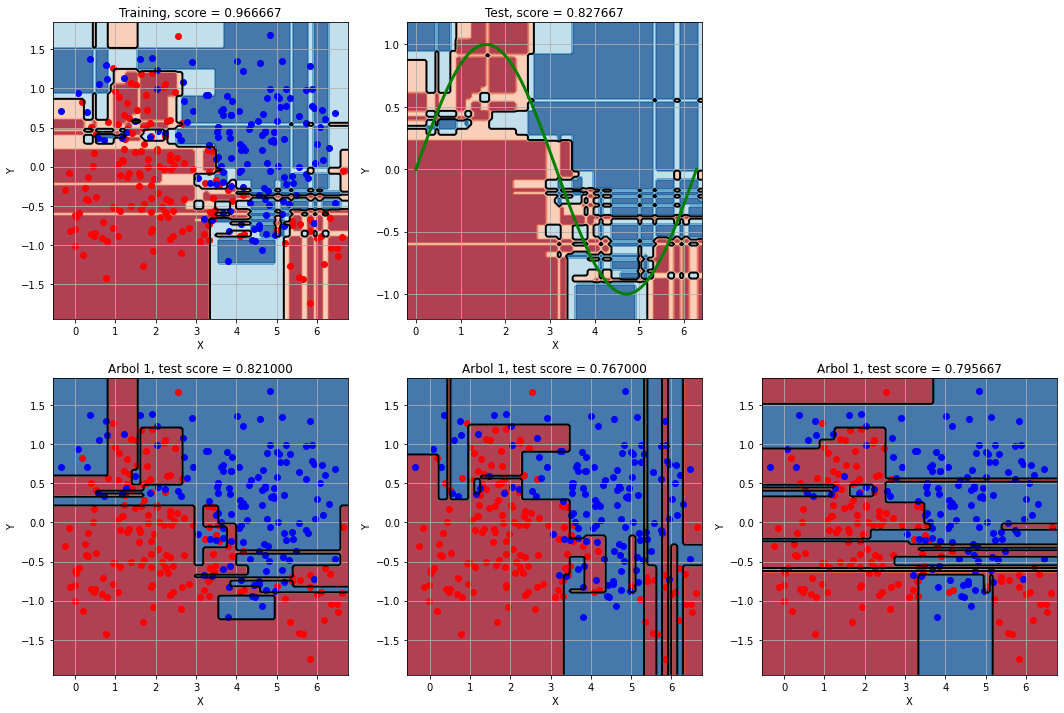

In [6]:
# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=3) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
                            for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))


# Gráficas:
plt.figure(figsize=(18,12))
plt.subplot(231)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(234)
plotModel(x,y,clase,clf.estimators_[0],"Arbol 1, test score = %f" % (scores_single_trees_test[0]))
plt.subplot(235)
plotModel(x,y,clase,clf.estimators_[1],"Arbol 1, test score = %f" % (scores_single_trees_test[1]))
plt.subplot(236)
plotModel(x,y,clase,clf.estimators_[2],"Arbol 1, test score = %f" % (scores_single_trees_test[2]))

plt.subplot(232)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))


<div style="background-color:#AAEEAA;padding:20px;border:solid;">A continuación se realiza el cálculo el acierto del conjunto con en train y en test con respecto al número de clasificadores combinados. Puedes utilizar la función suministrada individualPredictions, que dado un conjunto de datos y otro de clasificadores devuelve las clasificaciones de cada clasificador base para cada ejemplo
</div>

In [7]:
# individualPredictions: Devuelve la predicción para cada dato por parte de cada clasificador 
#                        de un conjunto de clasificadores
#     Entrada:
#         - ens: lista con un conjunto de clasificadores
#         - X  : ejemplos a clasificar
#     Salida:
#         - Matriz de predicciones de número de ejemplo filas y no. clasificadores columnas
def individualPredictions(ens, X):
    P = np.ones((X.shape[0],len(ens)))
    it = 0
    for dt in ens:
        P[:,it] = dt.predict(X)
        it += 1

    return P



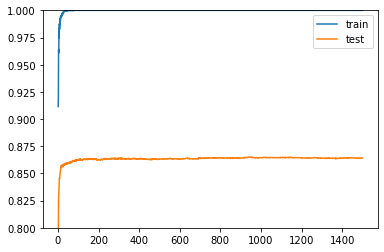

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

def accuracy(ens, pr, y):
    pr = np.cumsum(pr,axis=1)/np.arange(1.,pr.shape[1]+1,1.)
    pr[pr>0.5] = 1
    pr[pr<=0.5] = 0

    iclases_test = np.zeros(np.array([y]).T.shape)
    iclases_test[y==ens.classes_[0]] = 0
    iclases_test[y==ens.classes_[1]] = 1

    Pok = pr==iclases_test
    return np.array(Pok.sum(axis=0),dtype=float)/len(y)

    
# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.8, random_state=1)

n_trees = 1500
clf = RandomForestClassifier(n_estimators=n_trees)
clf.fit(X_train, clases_train)

P = individualPredictions(clf.estimators_, X_train)
accu_tr = accuracy(clf,P,clases_train)

P = individualPredictions(clf.estimators_, X_test)
accu_ts = accuracy(clf,P,clases_test)

plt.plot(range(1,n_trees+1),accu_tr,label="train")
plt.plot(range(1,n_trees+1),accu_ts,label="test")
plt.ylim([0.8,1])
_ = plt.legend()


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica describe cómo evoluciona el error en en entrenemiento y test con respecto al número de árboles que se combinan en el conjunto ¿Se observa sobre ajuste al aumentar el número de clasificadores? Es decir, ¿sube el error en test a partir de algún umbral del número de clasificadores?<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">
(5) Respuesta: No, no sube el error a partir de cierto umbral de número de clasificadores. Hemos realizado pruebas con 250, 500, 1000 y 1500 estimadores, y apenas hemos visto una mejora en los resultados.
</div>

### Gradient Boosting para regresión



In [10]:
from sklearn.tree import DecisionTreeRegressor

def plot_par(t,x,y,res,pred,F):
    m = np.floor(np.min(y)-1)
    M = np.ceil(np.max(y)+1)
    plt.subplot(T,2,t*2+1)
    plt.stem(x,res,label='residuos')
    plt.plot(x,pred,label='h'+str(t),c='y')
    plt.ylim((m,M))
    plt.legend()
    plt.subplot(T,2,t*2+2)
    plt.plot(x,y,label='objetivo')
    plt.plot(x,F,label='F'+str(t),c='y')
    plt.ylim((m,M))
    plt.legend()

class SquaredErrorLoss:
    def F0(_, X, y):
        return np.ones(len(X))*np.mean(y)

    def residuos(_, y,F):
        return y - F

    def paso_newton(_, y, res, pred):
        return 1
    
class LogLoss:
    def F0(_, X, y):
        ymed = np.mean(y)
        return np.ones(len(X)) * 0.5 * np.log((1+ymed)/(1-ymed))

    def residuos(_, y,F):
        return 2.0*y/(1+np.exp(2.0*y*F))

    def paso_newton(_, y, res, pred):
        return np.sum(res*pred)/np.sum(res*pred*pred*(2.0*y-res))    
     
def GB(x,y,loss,T):
    F = loss.F0(x, y)

    #plotting
    plt.figure(figsize=(12, T*4))
    plot_par(0,x,y,y,F,F)

    for t in range(1,T):
        res = loss.residuos(y,F)
        # Modelo ajustado a residuos
        lr = DecisionTreeRegressor(max_depth=1)
        lr.fit(x.reshape(-1,1),res)
        # Update
        pred = lr.predict(x.reshape(-1,1))
        paso = loss.paso_newton(y, res, pred)
        
        F = F + paso*pred
        #plotting
        plot_par(t,x,y,res,pred,F)


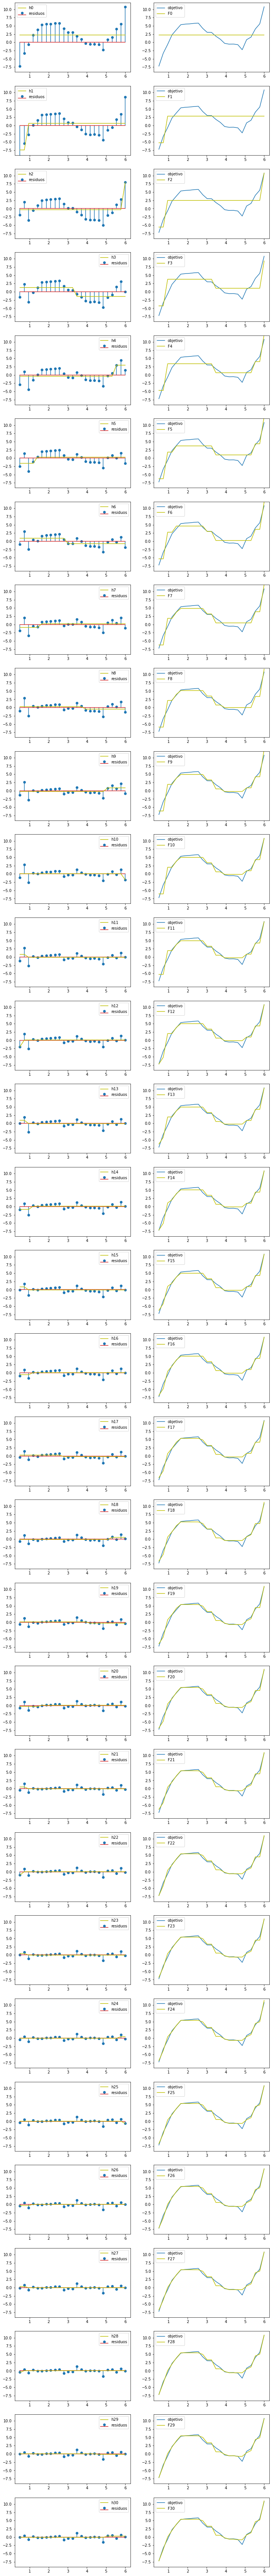

In [11]:
T = 31

# Gradient boosting ejemplo
def polinomio(x):
    return (x-1)*(x-4)*(x-5) + np.random.randn(len(x))*0.5

x = np.linspace(0.5,6,25)
y = polinomio(x)

loss = SquaredErrorLoss()

GB(x,y,loss,T)

### Gradient Boosting para clasificación

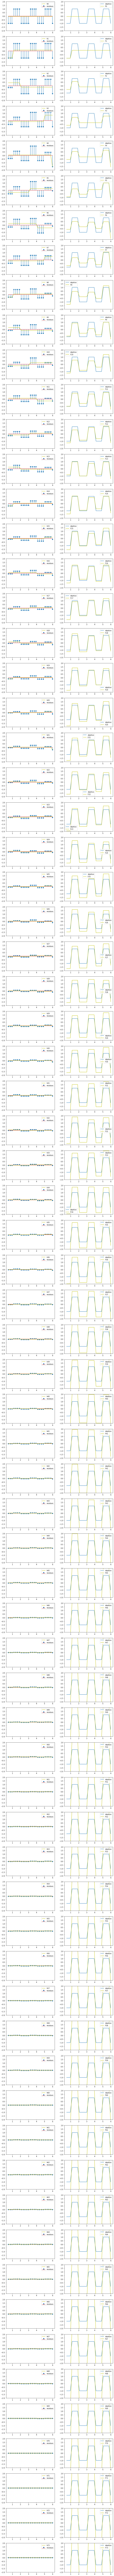

In [12]:
T = 74

# Gradient boosting ejemplo
def polinomio(x):
    return ((x + np.random.randn(len(x))*0.15).astype(int) % 2 ) * 2 - 1

x = np.linspace(0.5,6,25)
y = polinomio(x)

loss = LogLoss()

GB(x,y,loss,T)

#plt.savefig("clasf_gb.svg")

### 2.- Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 0.472 s.
Tiempo de clasificar 100 ejemplos: 0.01234 s.


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando conjuntos de clasificadores con 100 y 1000 árboles. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla comparando con lo obtenido en con árboles y SVM:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(6) Respuestas:

|  Tiempos (s)          | Árbol  | SVM  | RF100 | RF 1000 |
|-----------------------|--------|------|-------|---------|
| Entrenamiento con 300 | 0.001901    | 9.614101  | 0.1985  |  1.324   |
| Entrenamiento con 600 | 0.003601    | 15.123283  | 0.2416  |  1.605    |
| Clasificación con modelo entr. con 300 (10^6 ejemplos) |  0.740153   | 4.222413  | 64.98  | 317.7    |
| Clasificación con modelo entr. con 600 (10^6 ejemplos) |  1.089320   | 15.123283  | 97.05  | 1228    |

(+) Recuperar datos de la práctica anterior

(++) Rellenar estos datos ejecutando el código de arriba
</div>
<br/>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla comenta los resultados.<br/>

<ul>
<li>(7) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(8): Explica los resultados y comparalos con los de un solo árbol</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

<ul>
<li>(7): Los tiempos en ambos casos aumentan, aunque no de manera lineal.</li>
<li>(8): Los tiempos de clasificación de un solo árbol en comparación con varios es notoriamente menor. De hecho, Random Forest es un emseble method de Machine Learning, esto es que usa implicitamente otros modelos como es 'bagging method'. Esto tiene lógica ya que el proceso de clasificación es más complejo que en el caso de un único árbol, por lo que es entendible que se tarde mas en clasificar. </li>
</ul></div>

### 3.- Comparativa
Vamos a comparar los resultados de clasificación de algunos conjuntos de clasificadores y árboles de decisión.

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Completa el código de abajo para comparar un árbol de decisión y los conjuntos bagging, adaboost y random forest. Se debe obtener el acierto para los conjuntos de datos: pimaND, spamND, magic04 y sonar. Esto se hará usando validación cruzada de 10 hojas.<br/>
</div>

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

# Lista con los ficheros de datos
dataset_names = ['sensor.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=1
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [tree.DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
P        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))


pimaND.csv
DecisionTree: 32.3%% +- 6.07
RandomForest: 24.5%% +- 5.03
AdaBoost    : 27.3%% +- 5.13
Bagging     : 24.3%% +- 5.5


<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Resultados:

|  Error de test (%) $\pm$ desv      | Árbol  | RandomForest  | AdaBoost | Bagging |
|-----------------------|--------|------|-------|---------|
| Pima  | 33.6%% +- 4.65    | 23.2%% +- 4.54  | 27.3%% +- 5.17  | 24.1%% +- 5.69    |
| Spam  | 44.6%% +- 3.39    | 38%% +- 2.99  | 42.5%% +- 2.67  | 38.3%% +- 3.45    |
| Sonar | 23.5%% +- 7.06    | 17.3%% +- 4.99  | 11.5%% +- 6.11  | 20.7%% +- 7.18    |
| Magic | 18.2%% +- 0.715    |11.7%% +- 0.655  | 12.2%% +- 0.583  | 12.3%% +- 0.807    |

(+) Rellenar estos datos ejecutando el código implementado. Dar el error y la desviación estándar. Por ejemplo $15.0 \pm 3.4$
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados: Tal y como se puede observar en esta gráfica no hay un modelo que produzca mejores resultados en el 100% de los casos sobre los demás. Tal es así que por ejemplo para el conjunto de datos Pima y Spam los mejores resultados son del método Bagging y RandomForest. Mientras que para el conjunto Sonar el mejor método ha sido AdaBoost. Lo que si se aprecia es que el método de los árboles no da demasiados buenos resultados. Esta mejoría de los resultados con RandomForest, AdaBoost y Bagging respecto a árboles se debe a que estos tres mejores métodos son 'ensambing methods' es decir están formados por un conjunto de modelos predictivos que les dan más estabilidad y precisión. Es por eso que estos métodos tienen un menor problema con el sesgo y la varianza que si tiene el 'tree method'.

</div>
<br/>

### 4.- Atributos más importantes
Vamos a ver cuáles son los atributos más importantes de los conjuntos de datos analizados arriba. Al entrenar el conjunto se guarda en la variable feature\_importances\_ la importancia relativa de cada variable medida en función de cómo de alto aparece en cada árbol.

[('fAlpha', 0.242576521875745), ('fLength', 0.15495391190532012)]

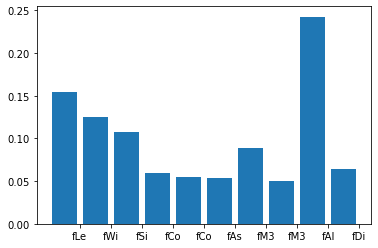

In [16]:
from sklearn.model_selection import train_test_split

# Lista con los ficheros de datos
dataset_names = ['sensor.csv', 'pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=4
d = pd.read_csv(dataset_names[idata], sep=',')
lVarsTarg = d.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(d.values[:,:-1], d.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

importanceDict = {}
for column, imp in zip(lVarsTarg, clf.feature_importances_):
    importanceDict[column] = imp

# creamos un diccionario que asocie a cada atributo del df, su importancia basada en el clasificador
importanceDict = {k: v for k, v in sorted(importanceDict.items(), key=lambda item: item[1])}

# Mostramos los atributos más relevantes
_ = plt.bar(np.arange(1,d.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,d.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]])

# los 2 atributos mas relevantes son
attr_sort = [] 
{attr_sort.append(a) for a in reversed(list(importanceDict.items()))}
attr_sort[:2]

<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Indica las dos variables más importante para cada conjunto de datos:

|  Error de test (%) $\pm$ desv      | Nombre Variable 1 | Nombre Variable 2 |
|-----------------------|--------|------|
| Pima  | glucose    | massIndex  |
| Spam  | capital_run_length_total    | capital_run_length_average  |
| Sonar | a11    | a12  |
| Magic | fAlpha    | fLength  |

(+) Rellenar estos datos 
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:En la tabla se muestran los atributos más importantes para cada dataset aplicando un modelo de random forest. Pero, ¿que quiere decir que estos atributos sean los mejores? Tecnicamente, se refiere a que el incremento en el error del modelo de predicción después de que el valor de dicho atributo ha sido permutado.Es decir, la importancia de atributos es el incremento del error del modelo cuando la información del atributo se “destruye”. Además, esta medida toma automáticamente en cuenta todas las interacciones con otros atributos. Por lo que nos arroja información de cuales son los atributos más significativos para este método de ML.
    

</div>
<br/>
